We have two possible modelling questions here:
1. does $x$ come from a double hit? Here $x$ is two dimensional. We treat this as a logistic regression problem: $y = \sigma(f(s, t))$ with y being 1 if the datapoint is double-hit or 0 if single hit. We dont observe y though as of now, so this won't work. Maybe train from simulations and predict from real data? Is there a dataset for this?
2. is $x$ high or low fitness? classify datapoints based on $s$ only, 1D. Then, we can show data on 2D plot, but I guess we wont learn much from the 2D plot except that high $s$ values are rare for low $t_0$.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal, spearmanr
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

palette = "Dark2"
colors = mpl.colormaps[palette].colors

<Axes: xlabel='sMax'>

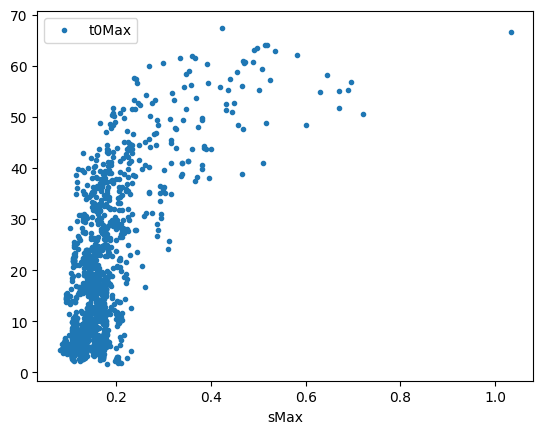

In [2]:
data = pd.read_csv("variantTrajectoryEstimates.csv")  # , usecols=["sMax", "t0Max"])
data.plot(x="sMax", y="t0Max", ls="", marker=".")  # TODO: ask why s>1

In [3]:
data

,pid,gene,aaChange,nonSynonymous,coVariants,sMax,t0Max,clusterType,varType
0,SardID_260,PHF6,PHF6_c.374+1G>A,True,5,0.269240,40.215066,1,elevated
1,SardID_260,SMC1A,SMC1A_p.R404Q,True,5,0.197850,2.232072,1,innate
2,SardID_260,SRSF2,SRSF2_p.P95L,True,5,0.130635,7.622626,1,innate
3,SardID_260,SRSF2,SRSF2_p.P95H,True,5,1.033030,66.546992,2,elevated
4,SardID_260,SRSF2,SRSF2_p.Y44H,True,5,0.161765,32.170912,1,innate
...,...,...,...,...,...,...,...,...,...
1937,939,TET2,TET2_p.L615fs,True,0,0.466563,55.958600,2,elevated
1938,2641,DNMT3A,DNMT3A_p.R823S,True,0,0.109053,6.005321,1,innate
1939,522,TET2,TET2_p.H682fs,True,0,0.112468,5.474850,1,innate
1940,2006,TP53,TP53_p.K139E,True,0,0.136274,3.955708,1,innate


In [4]:
def plot_gaussian(ax, mu, cov, c):
    # need this to rotate the Gaussians
    # eigen-decomposition of covariance
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    for p in (0.5, 0.9, 0.99):  # probability mass
        s = chi2.ppf(p, df=2)  # chi-square quantile
        width, height = 2 * np.sqrt(vals * s)  # radii along eigenvectors
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        e = Ellipse(
            xy=mu,
            width=width,
            height=height,
            angle=angle,
            fill=False,
            linewidth=1.5,
            color=c,
        )
        ax.add_patch(e)
        # ax.annotate(f"{int(p*100)}%", (mu[0]+width/2, mu[1]))

    # ax.set_aspect("equal")
    # ax.set_title("2D Gaussian confidence ellipses")
    return ax


def plot_nice(ax, means, covs, color, labels=None):
    for m, sigma, c in zip(means, covs, color):
        ax = plot_gaussian(ax, m, sigma, c=c)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 70])

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
[0.52317873 0.09256108 0.38426019]


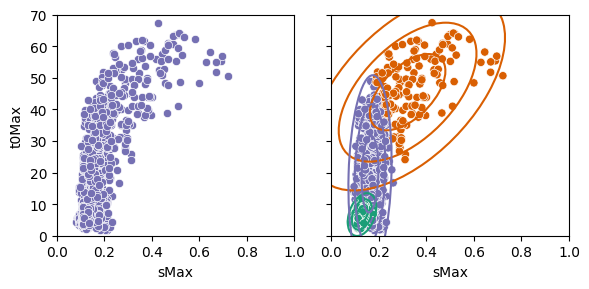

In [5]:
k_components = 3

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 3), layout="tight")
sns.scatterplot(data=data, x="sMax", y="t0Max", ax=ax[0], color="#7570b3")

gmm = BayesianGaussianMixture(
    n_components=k_components,
    covariance_type="full",
    tol=0.001,
    reg_covar=1e-06,
    max_iter=1000,
    n_init=1,
    init_params="random_from_data",
    weight_concentration_prior_type="dirichlet_process",
    # weight_concentration_prior=0.01,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=5,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=1,
    verbose_interval=10,
)

labels = gmm.fit_predict(data[["sMax", "t0Max"]].to_numpy())
print(gmm.weights_)
sns.scatterplot(data=data, x="sMax", y="t0Max", hue=labels, ax=ax[1], palette=palette)
plot_nice(ax[1], gmm.means_, gmm.covariances_, colors, labels)
ax[1].legend().set_visible(False)
plt.savefig("./dirichlet_3_components.png", dpi=700)
plt.show()

Initialization 0
  Iteration 10	 time lapse 0.01180s	 ll change 0.01447
  Iteration 20	 time lapse 0.01113s	 ll change 0.00459
  Iteration 30	 time lapse 0.01165s	 ll change 0.00076
  Iteration 40	 time lapse 0.01190s	 ll change 0.00001
Initialization converged. time lapse 0.04985s	 lower bound -1.62521.
[0.9 0.1]
[0.62950306 0.37049694]


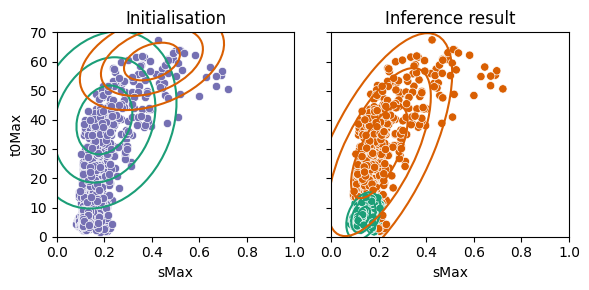

In [6]:
# PRIORS
n_features = 2  # 2D problem
k_components = 2

# means
# 1st component of the mixture
mean_s_1, mean_t_1 = 0.2, 40
mean_prior_1 = np.array([mean_s_1, mean_t_1], dtype=float)
# 2nd component of the mixture
mean_s_2, mean_t_2 = 0.4, 60
mean_prior_2 = np.array([mean_s_2, mean_t_2], dtype=float)
# combine them
mean_prior = np.array([mean_prior_1, mean_prior_2], dtype=float)
assert mean_prior.shape == (k_components, n_features), mean_prior.shape

# covariances
# 1st component of the mixture
var_s_1, var_t_1, cov_s_t_1 = 0.01, 100, 0.2  # TODO
cov_prior_1 = np.array([[var_s_1, cov_s_t_1], [cov_s_t_1, var_t_1]], dtype=float)
assert cov_prior_1.shape == (2, 2), cov_prior_1.shape
# 2nd component of the mixture
var_s_2, var_t_2, cov_s_t_2 = 0.01, 30, 0.2  # TODO
cov_prior_2 = np.array([[var_s_2, cov_s_t_2], [cov_s_t_2, var_t_2]], dtype=float)
assert cov_prior_2.shape == (2, 2), cov_prior_2.shape
# combine
cov_prior = np.array([cov_prior_1, cov_prior_2])
assert cov_prior.shape == (k_components, n_features, n_features), cov_prior.shape

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 3), layout="tight")
sns.scatterplot(data=data, x="sMax", y="t0Max", ax=ax[0], color="#7570b3")
plot_nice(ax[0], [mean_prior_1, mean_prior_2], [cov_prior_1, cov_prior_2], colors)
ax[0].set_title("Initialisation")
gmm = GaussianMixture(
    n_components=k_components,
    covariance_type="full",
    reg_covar=1e-09,
    tol=1e-6,
    max_iter=1000,
    weights_init=[0.9, 0.1],
    means_init=mean_prior,
    precisions_init=np.linalg.inv(cov_prior),  # not the best
    random_state=None,
    warm_start=False,
    verbose=2,
    verbose_interval=10,
)

labels = gmm.fit_predict(data[["sMax", "t0Max"]].to_numpy())
print(gmm.weights_init)
print(gmm.weights_)
sns.scatterplot(data=data, x="sMax", y="t0Max", hue=labels, ax=ax[1], palette=palette)
plot_nice(ax[1], gmm.means_, gmm.covariances_, colors, labels)
ax[1].legend().set_visible(False)
ax[1].set_title("Inference result")
plt.savefig("./gmm_2_components.png", dpi=700)
plt.show()

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
Initialization converged.
[1.03895847e-001 4.92371550e-002 6.48463846e-004 6.47908828e-004
 2.57104195e-001 6.46559800e-004 2.45213383e-002 2.09610651e-001
 6.43631121e-004 6.42324978e-004 6.41022540e-004 6.39723789e-004
 1.63886182e-001 6.36015405e-004 6.33614758e-004 1.85960324e-001
 4.99265146e-006 4.94321927e-008 4.89427650e-010 4.84581832e-012
 4.79783992e-014 4.75033655e-016 4.70330352e-018 4.65673616e-020
 4.61062986e-022 4.56498006e-024 4.51978224e-026 4.47503192e-028
 4.43072467e-030 4.38685611e-032 4.34342189e-034 4.30041771e-036
 4.25783932e-038 4.21568250e-040 4.17394306e-042 4.13261690e-044
 4.09169990e-046 4.05118802e-048 4.01107724e-050 3.97136361e-052
 3.93204318e-054 3.89311206e-056 3.85456639e-058 3.81640237e

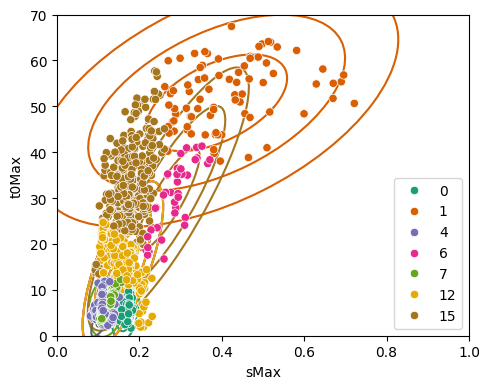

In [7]:
gmm = BayesianGaussianMixture(
    n_components=100,
    covariance_type="full",
    tol=0.001,
    reg_covar=1e-06,
    max_iter=1000,
    n_init=1,
    init_params="random_from_data",
    weight_concentration_prior_type="dirichlet_process",
    # weight_concentration_prior=0.01,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=5,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=1,
    verbose_interval=10,
)

labels = gmm.fit_predict(data[["sMax", "t0Max"]].to_numpy())
print(gmm.weights_)
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
plot_nice(ax, gmm.means_, gmm.covariances_, colors, labels)
ax = sns.scatterplot(data=data, x="sMax", y="t0Max", hue=labels, ax=ax, palette=palette)
plt.savefig("./dirichlet_100_components.png", dpi=700)
plt.show()

Initialization 0
  Iteration 10	 time lapse 0.01666s	 ll change 0.00002
Initialization converged. time lapse 0.02089s	 lower bound 1.74971.


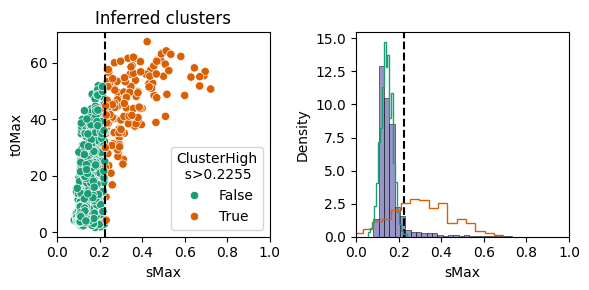

In [31]:
gmm = GaussianMixture(
    n_components=2,
    covariance_type="full",
    reg_covar=1e-09,
    tol=1e-6,
    max_iter=1000,
    # weights_init=[0.9, 0.1],
    # means_init=mean_prior,
    # precisions_init=np.linalg.inv(cov_prior),  # not the best
    random_state=None,
    warm_start=False,
    verbose=2,
    verbose_interval=10,
)

labels = gmm.fit_predict(data["sMax"].to_numpy().reshape(-1, 1))
data["ClusterHigh"] = labels
data["ClusterHigh"] = data["ClusterHigh"].astype(bool)
decision_boundary = data.loc[data.ClusterHigh, "sMax"].min()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3), layout="tight")
ax[0].set_title(f"Inferred clusters")
ax[0].axvline(x=decision_boundary, color="black", linewidth=1.5, ls="--")
sns.scatterplot(
    data=data, x="sMax", y="t0Max", hue="ClusterHigh", ax=ax[0], palette=palette
)
ax[0].legend(title=f"ClusterHigh\n  s>{decision_boundary:.4f}")
sns.histplot(
    data=data["sMax"], stat="density", ax=ax[1], color="#7570b3", binwidth=0.025
)
ax[1].set_xlim([0, 1])
ax[1].axvline(x=decision_boundary, color="black", linewidth=1.5, ls="--")

for mu, var, c in zip(gmm.means_, gmm.covariances_, mpl.colormaps[palette].colors):
    s = np.random.normal(mu, np.sqrt(var.ravel()), 1000)
    ax[1].hist(s, 20, density=True, histtype="step", color=c, align="mid")

plt.savefig("./gmm_2_components_1D.svg", dpi=700)
plt.show()

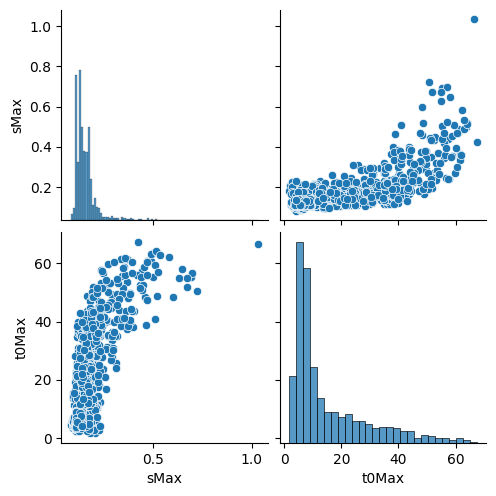

In [9]:
sns.pairplot(
    data[["sMax", "t0Max"]],
)

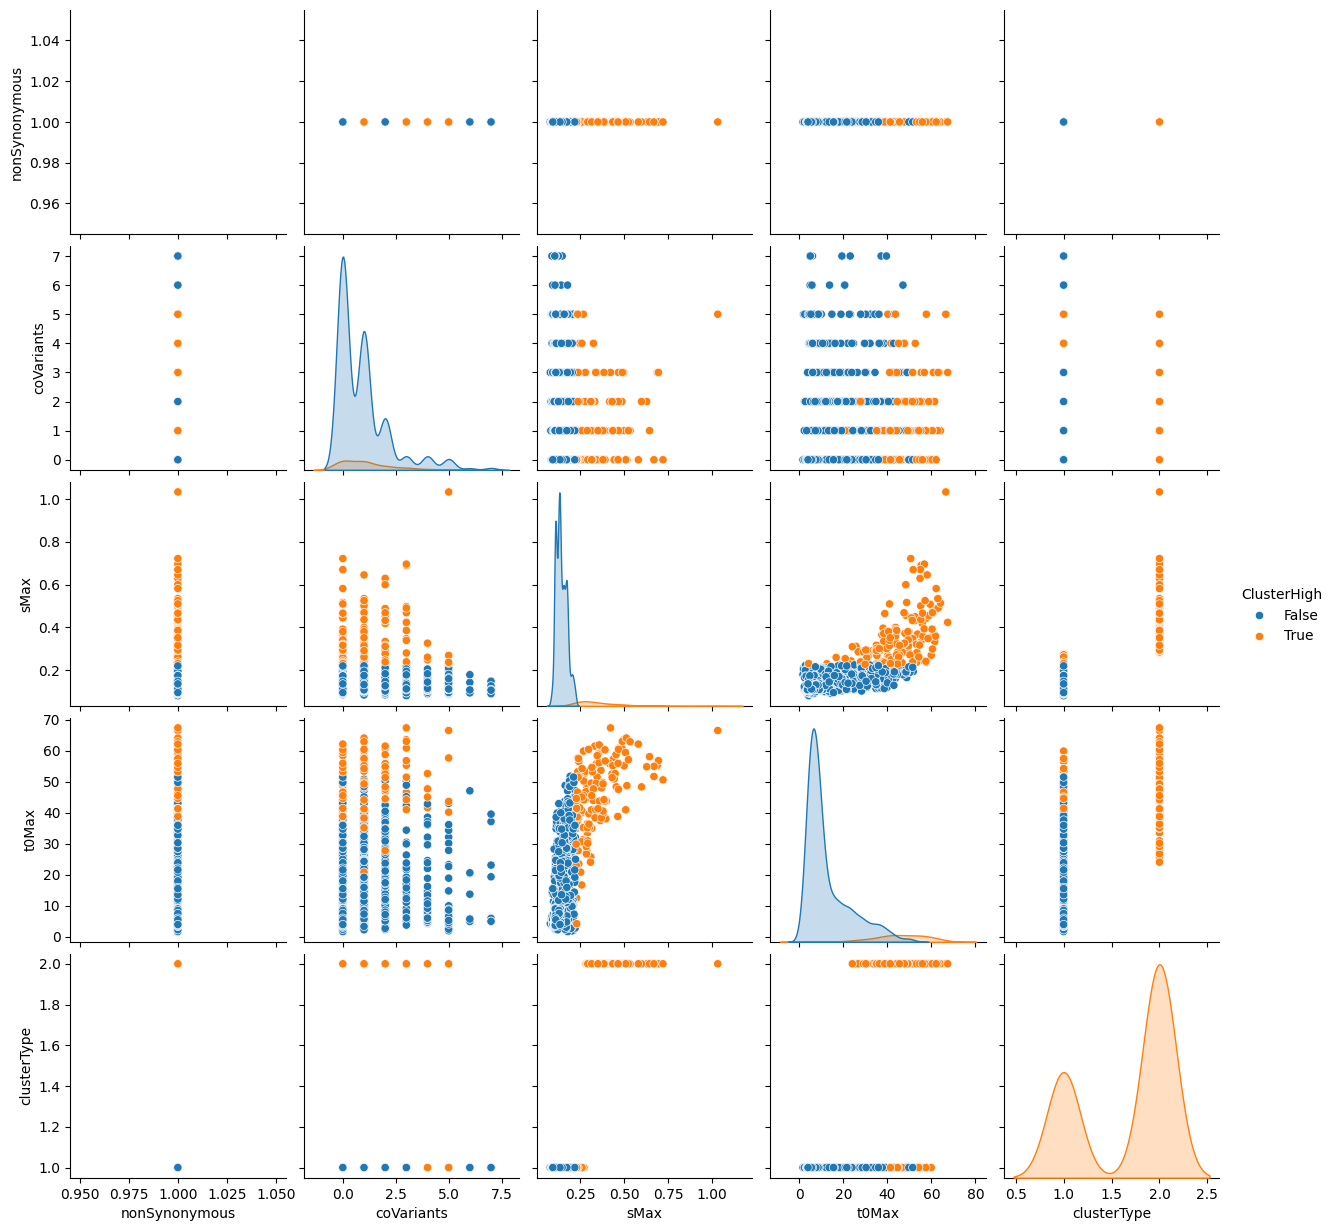

In [23]:
sns.pairplot(data, hue="ClusterHigh")

<Axes: >

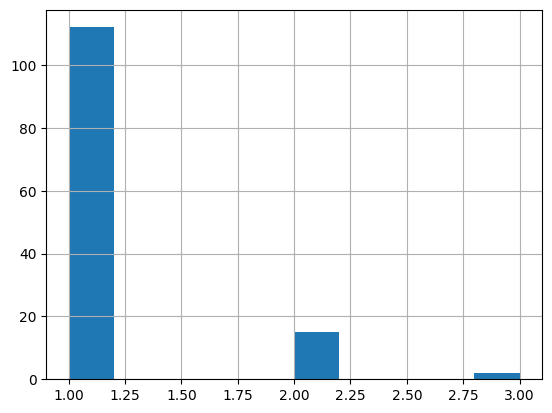

In [24]:
data.loc[data.ClusterHigh, "pid"].value_counts().hist()

In [25]:
data.loc[~data.ClusterHigh, "gene"].value_counts()

gene
DNMT3A    873
TET2      436
ASXL1      77
TP53       53
SF3B1      36
JAK2       31
CBL        29
SRSF2      24
PPM1D      15
NF1        13
KRAS       11
NOTCH1     11
ZRSR2      11
KDM6A      10
EZH2       10
RUNX1      10
KMT2A      10
BCORL1      9
CDKN2A      8
RAD21       7
STAT3       7
GNAS        6
CREBBP      6
U2AF1       6
BRCC3       5
BCOR        5
ETNK1       4
GATA1       4
CALR        4
MYD88       4
IDH2        4
PTPN11      4
SMC1A       3
CBLC        3
JAK3        3
NRAS        3
SETBP1      3
WT1         3
GNB1        3
STAG2       2
ETV6        2
KIT         2
SMC3        2
LUC7L2      2
BRAF        2
CTCF        2
CSF3R       2
PHF6        2
GATA2       2
SH2B3       2
CEBPA       2
SF1         1
CUX1        1
PTEN        1
ATRX        1
FBXW7       1
DDX41       1
Name: count, dtype: int64

In [26]:
data.loc[data.ClusterHigh, "gene"].value_counts()

gene
TET2      61
JAK2      15
DNMT3A    12
SRSF2     12
ASXL1      9
SF3B1      8
U2AF1      5
IDH1       3
TP53       3
NRAS       3
MPL        2
NOTCH1     2
CBL        2
PTPN11     1
PHF6       1
GNAS       1
ETV6       1
ZRSR2      1
PPM1D      1
BCOR       1
GATA2      1
KDM6A      1
MYD88      1
ETNK1      1
Name: count, dtype: int64

<Axes: >

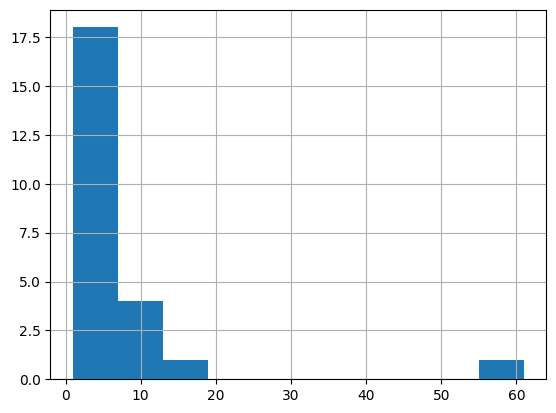

In [27]:
data.loc[data.ClusterHigh, "gene"].value_counts().hist()

In [13]:
spearmanr(data[["sMax", "t0Max"]])  # reject H0 -> correlation, stat>0 so positive corr

SignificanceResult(statistic=np.float64(0.5841967204897515), pvalue=np.float64(4.2374365496707285e-178))